## Beautiful Demo

Loads training data and shows an example training face

reading csv: 6.277865171432495
formatting to numpy matrices: 6.5999250411987305
picking random data: 0.014769792556762695
Formatting data: 4.9114227294921875e-05


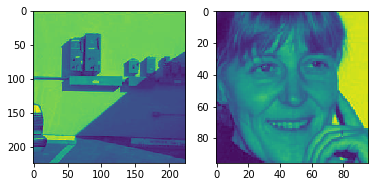

In [18]:
from matplotlib import pyplot as plt
from read_data import training_validation

from time import time
from random import choice

(training_images, training_labels), (test_images, test_labels) = training_validation()

sample_image_positive = choice(training_images)
sample_image_negative = choice(test_images)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(sample_image_positive)
ax2.imshow(sample_image_negative)
plt.show()



## Example of feature selection used

-0.181337163111
-0.147314458603
-0.0924428281224
4.91141678771
4.96471765996


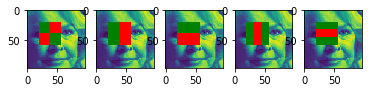

In [2]:
from features import *
from processing import IntegralImage

fsize = FeatureSize(0.2, 0.2, 0.4, 0.4)
ii = IntegralImage(sample_image_positive)
ii.process()
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

f = Feature(fsize, A)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, B1)
f.print_feature(ii, ax2)
print(f.calculate(ii))

f = Feature(fsize, B2)
f.print_feature(ii, ax3)
print(f.calculate(ii))

f = Feature(fsize, C1)
f.print_feature(ii, ax4)
print(f.calculate(ii))

f = Feature(fsize, C2)
f.print_feature(ii, ax5)
print(f.calculate(ii))


plt.show()

## Example of Feature Generation

In [3]:
from features import *
count = 0
for sz in generate_all_sizes():
    count += 1
print(count)

225


## Format training and test data

The format is adapted for the special ada boosted version, to extract features, therefore to train the normal bayes
we have to transpose the data to get image x features instead of features x images.

In [4]:
from read_data import get_trainable_data
training, test, IItraining, IItest, all_features, outTrain, outTest = get_trainable_data(training_images, test_images)

## Display of Integral Image

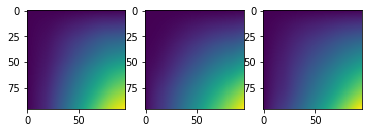

In [5]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(IItraining[0].ii)
ax2.imshow(IItraining[200].ii)
ax3.imshow(IItraining[400].ii)

plt.show()


## Testing Naive Bayes 

Naive bayes based on Normal distribution

Number of tests:  725
Avarage detection rate: 0.0011979448384252089
Success rate: 0.8082758620689655
False positives 0.03310344827586207
False negatives 0.15862068965517243


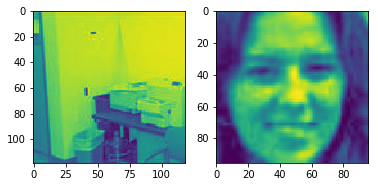

In [6]:
from naive_bayes import naive_bayes
from wrapper_for_bayes import wrapper
from tests import simple

# Bayes is weak when there's to many features.
training_for_bayes = training[500:510].T
test_for_bayes = test[500:510].T


classifier = naive_bayes()
classifier.train(training_for_bayes, training_labels)

# Wrap it so it remembers it features so it can be used in detector later

bayes_features = all_features[500:510]
bayes = wrapper(classifier, bayes_features)

p = plt.subplots(1, 2)

simple(bayes, IItest, test_labels, test_images, p)

plt.show()


## Example of a single feature boosted classifier

A bunch of these are combined in the cascade

Number of tests:  725                                     
Avarage detection rate: 0.0005229256070893386
Success rate: 0.88
False positives 0.07448275862068965
False negatives 0.04551724137931035


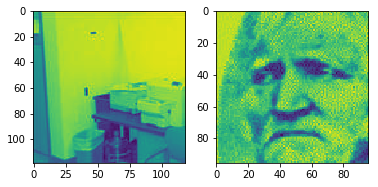

In [7]:
from ada_boost import boosted_classifier
from tests import simple

# Constructor takes num of features
boost = boosted_classifier(2)
boost.train(training, all_features, training_labels)
p = plt.subplots(1, 2)

simple(boost, IItest, test_labels, test_images, p)

plt.show()



## The one and only... Cascade

There is a huge problem with opimizing false positives versus retaining a minimal success rate
in our implementation. 

If minimal success rate is above a certain threshold the innerloop of the cascade 
trainer will never terminate. Because to live up to the treshhold the binary search
increases bias to let more through. This somehow results in a higher success rate
but also much higher false positives.

Perhaps its a implementation bug.

To get rid of this just set second argument in cascade to 0

Starting training
Round: 1, Currently: 1.0,  Target is: 0.1688
Current 1.0, Goal 0.7, Number Of Features 1
Round: 2, Currently: 0.31,  Target is: 0.1                
Current 0.31, Goal 0.217, Number Of Features 2
Round: 3, Currently: 0.17103448275862068,  Target is: 0.1 
Current 0.17103448275862068, Goal 0.11972413793103447, Number Of Features 3
Current 0.1399373040752351, Goal 0.11972413793103447, Number Of Features 4
Current 0.1399373040752351, Goal 0.11972413793103447, Number Of Features 5
Current 0.1399373040752351, Goal 0.11972413793103447, Number Of Features 6
Current 0.1399373040752351, Goal 0.11972413793103447, Number Of Features 7
Current 0.1399373040752351, Goal 0.11972413793103447, Number Of Features 8
Current 0.1399373040752351, Goal 0.11972413793103447, Number Of Features 9
Current 0.1399373040752351, Goal 0.11972413793103447, Number Of Features 10
Current 0.12438871473354232, Goal 0.11972413793103447, Number Of Features 11
Current 0.12438871473354232, Goal 0.1197241379310

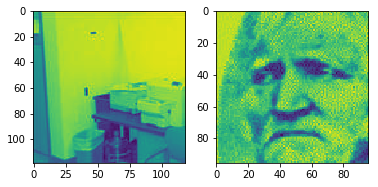

In [9]:
from cascade import cascade
from tests import simple

# Argument zero is False positive improvement, arg one is minimal success rate arg 2 is maximum classifiers.

c = cascade(0.7, 0.0, 50)
# Last arg is target False positive
c.train(IItraining, training_labels, 0.1)

p = plt.subplots(1, 2)

simple(c, IItest, test_labels, test_images, p)

plt.show()


## Comparison in Object detection using sliding window

Better than Eigen faces but still meh.. might be that training data is misrepresentative.

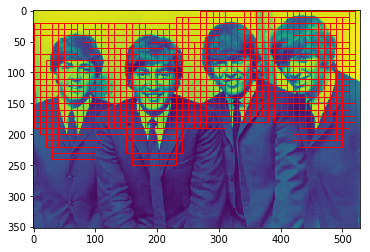

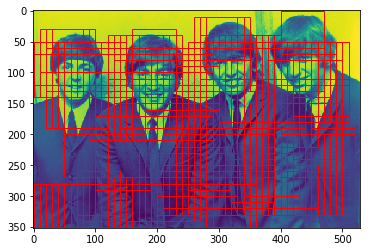

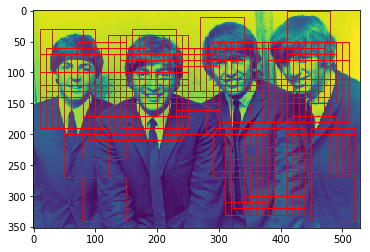

In [17]:
from detector import detector
from processing import load_image, grey_scale


window_start_dim = (70, 70)
window_stop_dim = (80, 80)
size_increase = 2
stride = 10


bayes_detector = detector(window_start_dim, window_stop_dim, size_increase, stride, bayes)
boost_detector = detector(window_start_dim, window_stop_dim, size_increase, stride, boost)
cascade_detector = detector(window_start_dim, window_stop_dim, size_increase, stride, c)


im_path = "/Users/jonasvalfridsson/me/singularity/RRTOD/beatles.jpg"

image = grey_scale(load_image(im_path))

bsfig, bs = plt.subplots(1, 1)
bofig, bo = plt.subplots(1, 1)
cafig, ca = plt.subplots(1, 1)


bayes_detector.detect(image, bs)
boost_detector.detect(image, bo)
cascade_detector.detect(image, ca)

bs.imshow(image)
bo.imshow(image)
ca.imshow(image)

plt.show()


# Store model in a pickle if one wants to use it later

In [12]:
import pickle

model = open("Cascade_Model.pkl", "wb")

pickle.dump(c, model)
model.close()

In [ ]:
import pickle

model = open("Cascade_Model.pkl", "rb")
cas = pickle.load(model)
model.close()

# Use Cas here, its already trained.
